In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [51]:
import re

def get_results(data):
    keys = ["bbox_AP", "segm_AP"]
    results = {}
    matches = re.findall(r'{.*?}', data)
    for i,match in enumerate(matches):
        match = ast.literal_eval(match)
        results[keys[i]] = match
    return results

In [52]:
import os
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator

def convert_tb_data(root_dir, sort_by=None):
    def convert_tfevent(filepath):
        return pd.DataFrame([parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )

    columns_order = ['wall_time', 'name', 'step', 'value']
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by:
        all_df = all_df.sort_values(by=sort_by)
    return all_df


### Hyperparametros

In [53]:
import ast

#results = open("./../models/Glass_models/results.txt", "r")
results = open("./../models/CA_models/results.txt", "r")
results = results.readlines()
count = 0
results_dict = {}
for line in results:
    line = line.strip("\n")
    line_by_spaces = line.split(" ")
    if line_by_spaces[0] == "Batch":
        line_by_comas = line.split(",")
        settings = {}
        for item in line_by_comas:
            setting = item.strip(" ").split(":")
            settings[setting[0]] = float(setting[1].strip(" ")) 
        results_dict[count] = settings
    if line_by_spaces[0] == "Mean":
        results = line.strip("Mean performance of 5 folds:")
        results = ast.literal_eval(results)
        combined_results = {}
        for key in results:
            for value in results[key]:
                new_key = key + "_" + value
                combined_results[new_key] = results[key][value]
        results_dict[count].update(combined_results)
        count += 1

print(results_dict)

{0: {'Batch size': 8.0, 'Learning rate': 0.0001, 'Batch size per image': 128.0, 'bbox_AP': 23.05438064595799, 'bbox_AP50': 48.182261344396565, 'bbox_AP75': 19.651568207595727, 'bbox_APs': 19.05771811570763, 'bbox_APm': 25.26138774874513, 'bbox_APl': 34.7784754975362, 'bbox_AP-dark': 17.39327531562332, 'bbox_AP-light': 28.715485976292666, 'segm_AP': 3.47806184078211, 'segm_AP50': 14.649590074907291, 'segm_AP75': 0.31372332239808975, 'segm_APs': 2.6056854152485704, 'segm_APm': 11.658238026367183, 'segm_APl': 2.854769333931658, 'segm_AP-dark': 3.425025184870415, 'segm_AP-light': 3.5310984966938057}, 1: {'Batch size': 8.0, 'Learning rate': 0.0001, 'Batch size per image': 256.0, 'bbox_AP': 15.857220611006108, 'bbox_AP50': 37.01398323273899, 'bbox_AP75': 9.623372199288397, 'bbox_APs': 14.20597029498066, 'bbox_APm': 18.956628710441727, 'bbox_APl': 23.439616646159234, 'bbox_AP-dark': 11.047518514928829, 'bbox_AP-light': 20.66692270708338, 'segm_AP': 2.5890963153006603, 'segm_AP50': 10.99965116

In [54]:
df = pd.DataFrame.from_dict(results_dict, orient='index')
df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
0,8.0,0.0001,128.0,23.054381,48.182261,19.651568,19.057718,25.261388,34.778475,17.393275,28.715486,3.478062,14.649590,0.313723,2.605685,11.658238,2.854769,3.425025,3.531098
1,8.0,0.0001,256.0,15.857221,37.013983,9.623372,14.205970,18.956629,23.439617,11.047519,20.666923,2.589096,10.999651,0.296105,1.740981,11.032842,3.204163,2.304137,2.874056
2,8.0,0.0001,512.0,10.720284,26.403043,5.000145,10.133428,13.705934,15.803626,8.088922,13.351647,2.182069,8.608967,0.192069,1.060969,11.286357,3.010726,2.137399,2.226739
3,8.0,0.0010,128.0,35.874289,69.349880,33.905435,31.187768,38.526042,47.911992,33.543436,38.205142,7.846790,30.884012,0.811952,6.366825,16.486795,6.170124,9.029898,6.663683
4,8.0,0.0010,256.0,36.599058,70.082215,33.753382,32.129126,39.313449,48.099655,32.274133,40.923983,7.918452,30.834067,0.855703,6.012410,16.364392,7.415559,8.431640,7.405265


In [55]:
df_sorted = df.sort_values(by=['bbox_AP','segm_AP'], ascending=False)
df_sorted.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
23,16.0,0.01,1024.0,39.904669,73.400241,39.423213,33.952353,42.728966,51.714121,36.424620,43.384718,10.268397,37.987392,1.650335,7.389481,18.547079,8.891089,10.779452,9.757342
22,16.0,0.01,512.0,39.654945,72.020143,37.882595,34.224680,42.647266,50.188506,36.464245,42.845646,9.942145,37.519086,1.491097,7.306086,18.083876,8.096782,11.000935,8.883356
21,16.0,0.01,256.0,39.187368,72.459813,36.567659,33.781079,42.058268,49.843249,36.257860,42.116877,10.035996,39.363549,1.217341,7.680624,17.430925,8.445545,10.862490,9.209502
8,8.0,0.01,512.0,38.608012,71.479406,36.944777,32.862945,41.217076,50.473990,36.858769,40.357256,10.016362,36.869022,1.321271,7.642528,17.545973,8.831683,11.318309,8.714415
20,16.0,0.01,128.0,37.829955,71.688338,36.118375,32.391214,40.199786,50.778793,35.509722,40.150187,9.408197,36.422439,1.169783,7.877605,17.482258,7.732673,10.237898,8.578495


In [56]:
df_sorted

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
23,16.0,0.0100,1024.0,39.904669,73.400241,39.423213,33.952353,42.728966,51.714121,36.424620,43.384718,10.268397,37.987392,1.650335,7.389481,18.547079,8.891089,10.779452,9.757342
22,16.0,0.0100,512.0,39.654945,72.020143,37.882595,34.224680,42.647266,50.188506,36.464245,42.845646,9.942145,37.519086,1.491097,7.306086,18.083876,8.096782,11.000935,8.883356
21,16.0,0.0100,256.0,39.187368,72.459813,36.567659,33.781079,42.058268,49.843249,36.257860,42.116877,10.035996,39.363549,1.217341,7.680624,17.430925,8.445545,10.862490,9.209502
8,8.0,0.0100,512.0,38.608012,71.479406,36.944777,32.862945,41.217076,50.473990,36.858769,40.357256,10.016362,36.869022,1.321271,7.642528,17.545973,8.831683,11.318309,8.714415
20,16.0,0.0100,128.0,37.829955,71.688338,36.118375,32.391214,40.199786,50.778793,35.509722,40.150187,9.408197,36.422439,1.169783,7.877605,17.482258,7.732673,10.237898,8.578495
15,16.0,0.0010,128.0,37.189663,71.054521,34.376947,32.622371,39.993320,47.539351,34.515167,39.864159,8.392643,31.736458,0.956799,6.967947,17.225782,6.343234,9.048448,7.736838
14,16.0,0.0010,64.0,36.961133,68.922785,34.436908,31.700129,39.814576,49.015411,32.418952,41.503313,7.658047,29.984290,1.025841,6.705928,16.136503,5.950495,8.025598,7.290496
17,16.0,0.0010,512.0,36.606289,68.319623,35.490101,31.391213,39.587697,47.799639,31.895392,41.317185,7.604960,30.088041,0.727206,5.497324,16.039634,6.980127,8.105443,7.104477
4,8.0,0.0010,256.0,36.599058,70.082215,33.753382,32.129126,39.313449,48.099655,32.274133,40.923983,7.918452,30.834067,0.855703,6.012410,16.364392,7.415559,8.431640,7.405265
16,16.0,0.0010,256.0,36.440389,69.623745,34.305677,30.651919,39.252006,49.678012,33.073301,39.807476,7.333873,28.797536,0.748763,5.425193,16.224075,6.250259,7.675143,6.992603


Los mejores modelos en este caso son el 50 y el 38. En terminos generales de bbox y segm el 50 es mejor pero no con mucha diferencia. Por eso no podemos concluir que ningun modelo es claramente mejor y abra que hacer una evaluacion mas en profundidad.

In [57]:
reduces_df = df[['Batch size', 'Learning rate', 'Batch size per image','bbox_AP', 'segm_AP']]
reduces_df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,segm_AP
0,8.0,0.0001,128.0,23.054381,3.478062
1,8.0,0.0001,256.0,15.857221,2.589096
2,8.0,0.0001,512.0,10.720284,2.182069
3,8.0,0.0010,128.0,35.874289,7.846790
4,8.0,0.0010,256.0,36.599058,7.918452


In [58]:
grouped_bs = reduces_df.groupby('Batch size')
group = grouped_bs.get_group(8.0)
grouped_lr = group.groupby('Learning rate')
print(grouped_lr.head())

   Batch size  Learning rate  Batch size per image    bbox_AP    segm_AP
0         8.0         0.0001                 128.0  23.054381   3.478062
1         8.0         0.0001                 256.0  15.857221   2.589096
2         8.0         0.0001                 512.0  10.720284   2.182069
3         8.0         0.0010                 128.0  35.874289   7.846790
4         8.0         0.0010                 256.0  36.599058   7.918452
5         8.0         0.0010                 512.0  35.673390   6.677225
6         8.0         0.0100                 128.0  33.068334   7.650243
7         8.0         0.0100                 256.0  35.402325   7.828221
8         8.0         0.0100                 512.0  38.608012  10.016362


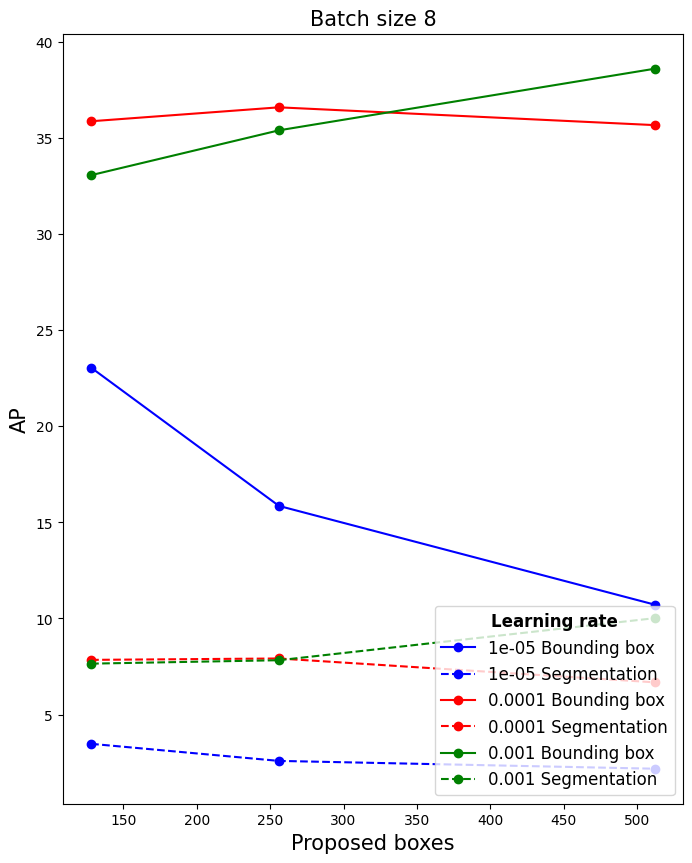

In [59]:

# Plot for batch size 8
fig, ax = plt.subplots(figsize=(8, 10))

line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green']

for j, (key_lr, group_lr) in enumerate(grouped_lr):
    for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
        ax.plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
ax.set_title('Batch size 8', fontsize=15)
ax.set_xlabel('Proposed boxes', fontsize=15)
ax.set_ylabel('AP', fontsize=15)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['1e-05 Bounding box', '1e-05 Segmentation', '0.0001 Bounding box', '0.0001 Segmentation', '0.001 Bounding box', '0.001 Segmentation'], loc='lower right', title='Learning rate', fontsize='large')
legend.get_title().set_fontsize('large')
legend.get_title().set_fontweight('bold')

plt.show()


In [60]:
group = grouped_bs.get_group(16.0)
grouped_lr = group.groupby('Learning rate')
print(grouped_lr.head())

    Batch size  Learning rate  Batch size per image    bbox_AP    segm_AP
9         16.0         0.0001                  64.0  27.931185   4.212415
10        16.0         0.0001                 128.0  23.208019   3.452306
11        16.0         0.0001                 256.0  15.886722   2.666179
12        16.0         0.0001                 512.0  11.306115   2.150739
13        16.0         0.0001                1024.0   9.282893   1.815809
14        16.0         0.0010                  64.0  36.961133   7.658047
15        16.0         0.0010                 128.0  37.189663   8.392643
16        16.0         0.0010                 256.0  36.440389   7.333873
17        16.0         0.0010                 512.0  36.606289   7.604960
18        16.0         0.0010                1024.0  33.384706   6.944061
19        16.0         0.0100                  64.0  35.612152   9.133936
20        16.0         0.0100                 128.0  37.829955   9.408197
21        16.0         0.0100         

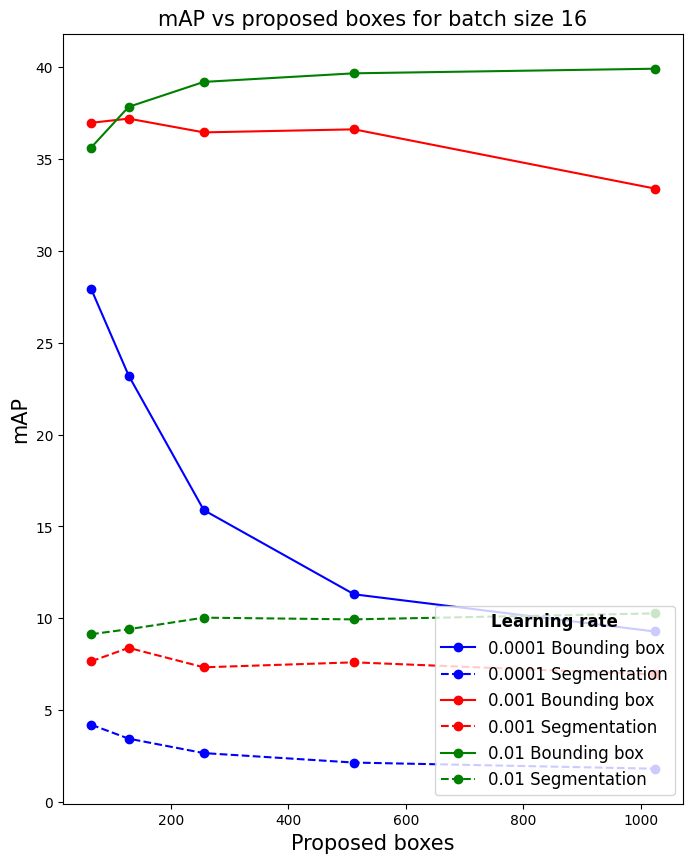

In [61]:
# Plot for batch size 16
fig, ax = plt.subplots(figsize=(8, 10))


line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green']

for j, (key_lr, group_lr) in enumerate(grouped_lr):
    for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
        ax.plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
ax.set_title('mAP vs proposed boxes for batch size 16', fontsize=15)
ax.set_xlabel('Proposed boxes', fontsize=15)
ax.set_ylabel('mAP', fontsize=15)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['0.0001 Bounding box', '0.0001 Segmentation', '0.001 Bounding box', '0.001 Segmentation', '0.01 Bounding box', '0.01 Segmentation'], loc='lower right', title='Learning rate', fontsize='large')
legend.get_title().set_fontsize('large')
legend.get_title().set_fontweight('bold')

plt.show()

According to the following figure, a pattern can start to be intuited. Clearly, as expected, the larger the batch size, the better the performance generally. Also, higher learning rates seem to be better, where in general 1e-5 does not learn in any model and 0.001 is the best, it might be worth trying higher learning rates. In relation to bspi, it can be seen that in configurations that seem optimal (bs=8,10 and lr=0.001) the best ranges seem to be 128,256. This may be because a low bspi causes not enough regions of interest to be proposed and a high bspi causes too many to be proposed.

### Folds

In [62]:
results = open("./../models/CA_models/results.txt", "r")
results = results.readlines()
count = 0
data_dict = {}

for i, line in enumerate(results):
    line = line.strip("\n")
    if line == str(count):
        data_list = results[i+3:i+8]
        data_len = len(data_list)
        data = [d.split("OrderedDict")[1] for d in data_list]
        results_to_dict = [get_results(d) for d in data]
        fold_dict = {}
        for i, r in enumerate(results_to_dict):
            fold_dict[i] = r
        data_dict[count] = fold_dict
        count += 1

print(data_dict)

{0: {0: {'bbox_AP': {'AP': 22.24081270611899, 'AP50': 44.34327153268006, 'AP75': 21.523095034049273, 'APs': 13.920192630129533, 'APm': 25.301212975182843, 'APl': 42.684563313267255, 'AP-dark': 15.5207071411492, 'AP-light': 28.960918271088783}, 'segm_AP': {'AP': 2.619716612425414, 'AP50': 12.523437921274969, 'AP75': 0.2744642689538312, 'APs': 1.5481365844873074, 'APm': 11.134383614636494, 'APl': 4.128712871287129, 'AP-dark': 1.5122741056504565, 'AP-light': 3.7271591192003712}}, 1: {'bbox_AP': {'AP': 25.145672993930162, 'AP50': 50.27939442183988, 'AP75': 22.992530499934865, 'APs': 19.284254229006535, 'APm': 28.630530802179816, 'APl': 33.833977631716174, 'AP-dark': 19.175428297934353, 'AP-light': 31.115917689925976}, 'segm_AP': {'AP': 3.3056200098584525, 'AP50': 14.313086594278948, 'AP75': 0.2029326759949168, 'APs': 2.3496768363297735, 'APm': 11.57218565377179, 'APl': 0.34203420342034196, 'AP-dark': 3.7377033802216455, 'AP-light': 2.8735366394952595}}, 2: {'bbox_AP': {'AP': 22.61505694609

In [63]:
data_dict_unified = {}
for count in data_dict:
    for fold in data_dict[count]:
        for value in data_dict[count][fold]:
            for metric in data_dict[count][fold][value]:
                new_key = value + "_" + metric
                if count not in data_dict_unified:
                    data_dict_unified[count] = {}
                if fold not in data_dict_unified[count]:
                    data_dict_unified[count][fold] = {}
                data_dict_unified[count][fold][new_key] = data_dict[count][fold][value][metric]

print(data_dict_unified)

{0: {0: {'bbox_AP_AP': 22.24081270611899, 'bbox_AP_AP50': 44.34327153268006, 'bbox_AP_AP75': 21.523095034049273, 'bbox_AP_APs': 13.920192630129533, 'bbox_AP_APm': 25.301212975182843, 'bbox_AP_APl': 42.684563313267255, 'bbox_AP_AP-dark': 15.5207071411492, 'bbox_AP_AP-light': 28.960918271088783, 'segm_AP_AP': 2.619716612425414, 'segm_AP_AP50': 12.523437921274969, 'segm_AP_AP75': 0.2744642689538312, 'segm_AP_APs': 1.5481365844873074, 'segm_AP_APm': 11.134383614636494, 'segm_AP_APl': 4.128712871287129, 'segm_AP_AP-dark': 1.5122741056504565, 'segm_AP_AP-light': 3.7271591192003712}, 1: {'bbox_AP_AP': 25.145672993930162, 'bbox_AP_AP50': 50.27939442183988, 'bbox_AP_AP75': 22.992530499934865, 'bbox_AP_APs': 19.284254229006535, 'bbox_AP_APm': 28.630530802179816, 'bbox_AP_APl': 33.833977631716174, 'bbox_AP_AP-dark': 19.175428297934353, 'bbox_AP_AP-light': 31.115917689925976, 'segm_AP_AP': 3.3056200098584525, 'segm_AP_AP50': 14.313086594278948, 'segm_AP_AP75': 0.2029326759949168, 'segm_AP_APs': 2.

In [64]:
data_df = pd.concat({(i,j): pd.DataFrame(data_dict_unified[i][j], index=[0]) for i in data_dict_unified.keys() 
                for j in data_dict_unified[i].keys()}, axis=0)

# Reset the index
data_df.reset_index(inplace=True)

# Rename the columns
data_df.columns = ['OuterKey', 'InnerKey'] + list(data_df.columns[2:])
data_df = data_df.drop(columns=["level_2"])

# Print the DataFrame
data_df.head()

,OuterKey,InnerKey,bbox_AP_AP,bbox_AP_AP50,bbox_AP_AP75,bbox_AP_APs,bbox_AP_APm,bbox_AP_APl,bbox_AP_AP-dark,bbox_AP_AP-light,segm_AP_AP,segm_AP_AP50,segm_AP_AP75,segm_AP_APs,segm_AP_APm,segm_AP_APl,segm_AP_AP-dark,segm_AP_AP-light
0,0,0,22.240813,44.343272,21.523095,13.920193,25.301213,42.684563,15.520707,28.960918,2.619717,12.523438,0.274464,1.548137,11.134384,4.128713,1.512274,3.727159
1,0,1,25.145673,50.279394,22.992530,19.284254,28.630531,33.833978,19.175428,31.115918,3.305620,14.313087,0.202933,2.349677,11.572186,0.342034,3.737703,2.873537
2,0,2,22.615057,45.980192,18.710704,20.243498,24.228740,33.030414,18.997648,26.232466,3.074792,12.997153,0.220380,2.362611,10.314946,3.241071,3.807545,2.342039
3,0,3,25.750667,52.285357,22.765521,24.985003,28.042672,31.598622,18.335814,33.165521,4.631721,18.135837,0.423847,3.998900,12.668573,3.041608,4.991516,4.271926
4,0,4,19.519693,48.023092,12.265990,16.855643,20.103783,32.744801,14.936780,24.102607,3.758460,15.278436,0.446992,2.769102,12.601102,3.520421,3.076088,4.440831


In [65]:
data_df_bbox = data_df[['OuterKey', 'bbox_AP_AP']]
data_df_segm = data_df[['OuterKey', 'segm_AP_AP']]

In [66]:
grouped_data_bbox_df = data_df_bbox.groupby('OuterKey').describe()
grouped_data_segm_df = data_df_segm.groupby('OuterKey').describe()
grouped_data_bbox_df.head()


bbox_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  23.054381  2.499619  19.519693  22.240813  22.615057   
1               5.0  15.857221  3.317339  11.308599  14.500120  15.382189   
2               5.0  10.720284  1.425057   8.444621  10.391037  11.124808   
3               5.0  35.874289  2.147207  33.049373  34.216386  36.700052   
4               5.0  36.599058  3.693920  30.023886  37.778721  38.096065   

                                
                75%        max  
OuterKey                        
0         25.145673  25.750667  
1         18.375067  19.720129  
2         11.465786  12.175170  
3         37.287906  38.117726  
4         38.307998  38.788619

In [67]:
grouped_data_segm_df.head()

segm_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  3.478062  0.764636  2.619717  3.074792  3.305620   
1               5.0  2.589096  0.470412  2.112791  2.169458  2.665441   
2               5.0  2.182069  0.509185  1.704314  1.877773  2.095002   
3               5.0  7.846790  0.866439  6.940327  7.093510  7.725099   
4               5.0  7.918452  0.960870  6.573713  7.443965  8.113241   

                              
               75%       max  
OuterKey                      
0         3.758460  4.631721  
1         2.733862  3.263930  
2         2.209831  3.023425  
3         8.659415  8.815601  
4         8.341900  9.119440

Text(0, 0.5, 'Value')

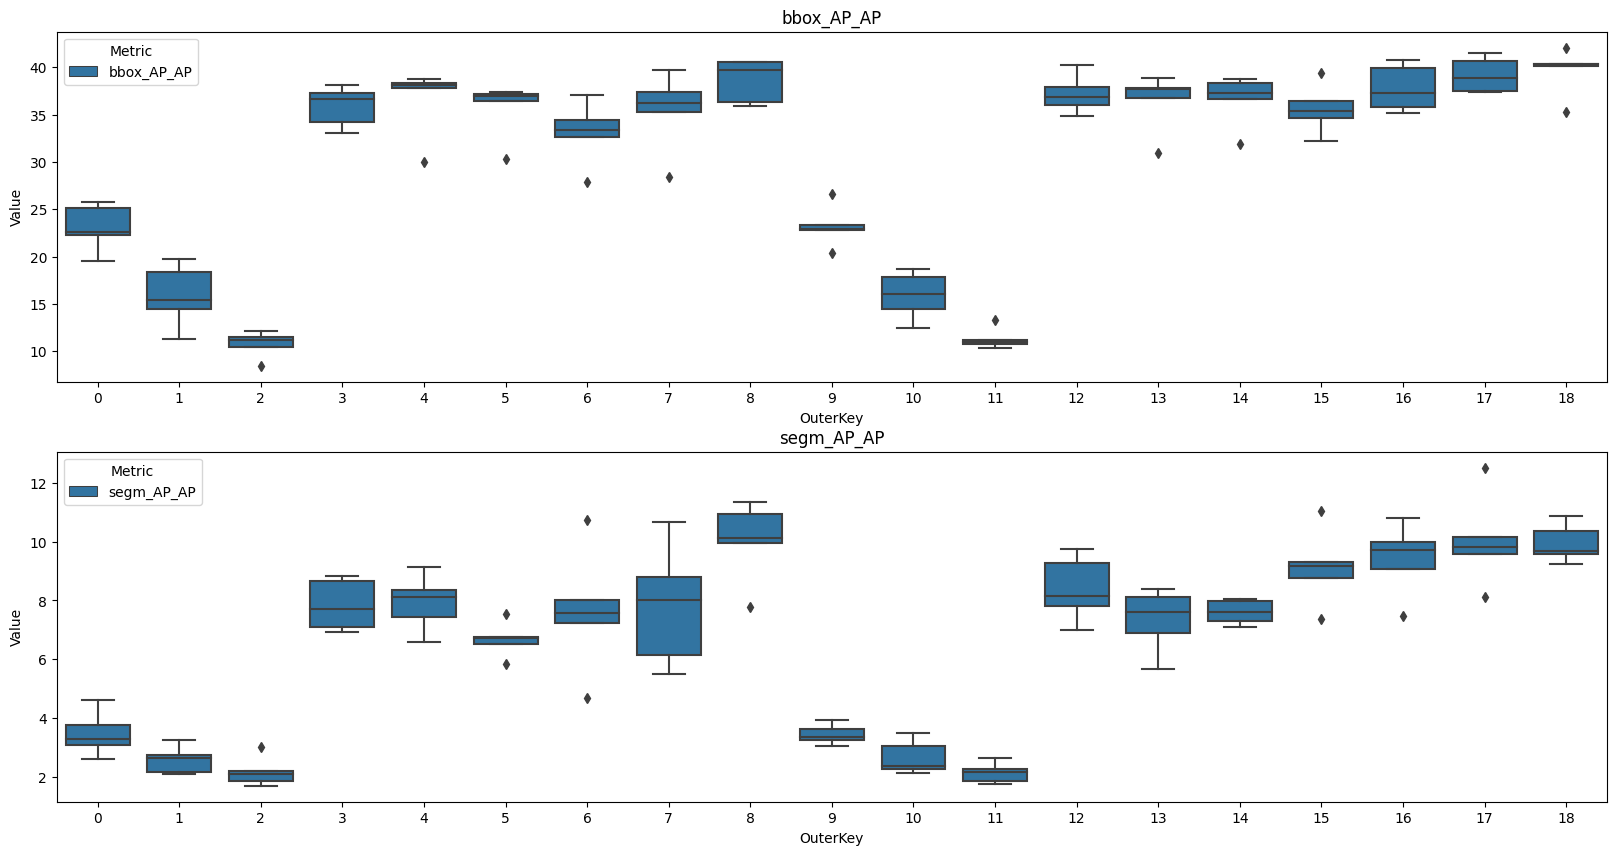

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

melted_bbox_df = data_df_bbox.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_bbox_df, hue='Metric', ax=ax[0])
ax[0].set_title('bbox_AP_AP')
ax[0].set_xlabel('OuterKey')
ax[0].set_ylabel('Value')

melted_segm_df = data_df_segm.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_segm_df, hue='Metric', ax=ax[1])
ax[1].set_title('segm_AP_AP')
ax[1].set_xlabel('OuterKey')
ax[1].set_ylabel('Value')

In [69]:
# Save a new df for sections of 12 rows of oute key of grouped_bbox_data_bbox_df
grouped_bbox_data_0_11 = grouped_data_bbox_df[0:9]
grouped_bbox_data_12_23 = grouped_data_bbox_df[9:18]
print(grouped_bbox_data_0_11.shape, grouped_bbox_data_12_23.shape)
grouped_bbox_data_0_11.head()

(9, 8) (9, 8)


bbox_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  23.054381  2.499619  19.519693  22.240813  22.615057   
1               5.0  15.857221  3.317339  11.308599  14.500120  15.382189   
2               5.0  10.720284  1.425057   8.444621  10.391037  11.124808   
3               5.0  35.874289  2.147207  33.049373  34.216386  36.700052   
4               5.0  36.599058  3.693920  30.023886  37.778721  38.096065   

                                
                75%        max  
OuterKey                        
0         25.145673  25.750667  
1         18.375067  19.720129  
2         11.465786  12.175170  
3         37.287906  38.117726  
4         38.307998  38.788619

In [70]:
grouped_segm_data_0_11 = grouped_data_segm_df[0:9]
grouped_segm_data_12_23 = grouped_data_segm_df[9:18]
print(grouped_segm_data_0_11.shape, grouped_segm_data_12_23.shape)
grouped_segm_data_0_11.head()

(9, 8) (9, 8)


segm_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  3.478062  0.764636  2.619717  3.074792  3.305620   
1               5.0  2.589096  0.470412  2.112791  2.169458  2.665441   
2               5.0  2.182069  0.509185  1.704314  1.877773  2.095002   
3               5.0  7.846790  0.866439  6.940327  7.093510  7.725099   
4               5.0  7.918452  0.960870  6.573713  7.443965  8.113241   

                              
               75%       max  
OuterKey                      
0         3.758460  4.631721  
1         2.733862  3.263930  
2         2.209831  3.023425  
3         8.659415  8.815601  
4         8.341900  9.119440

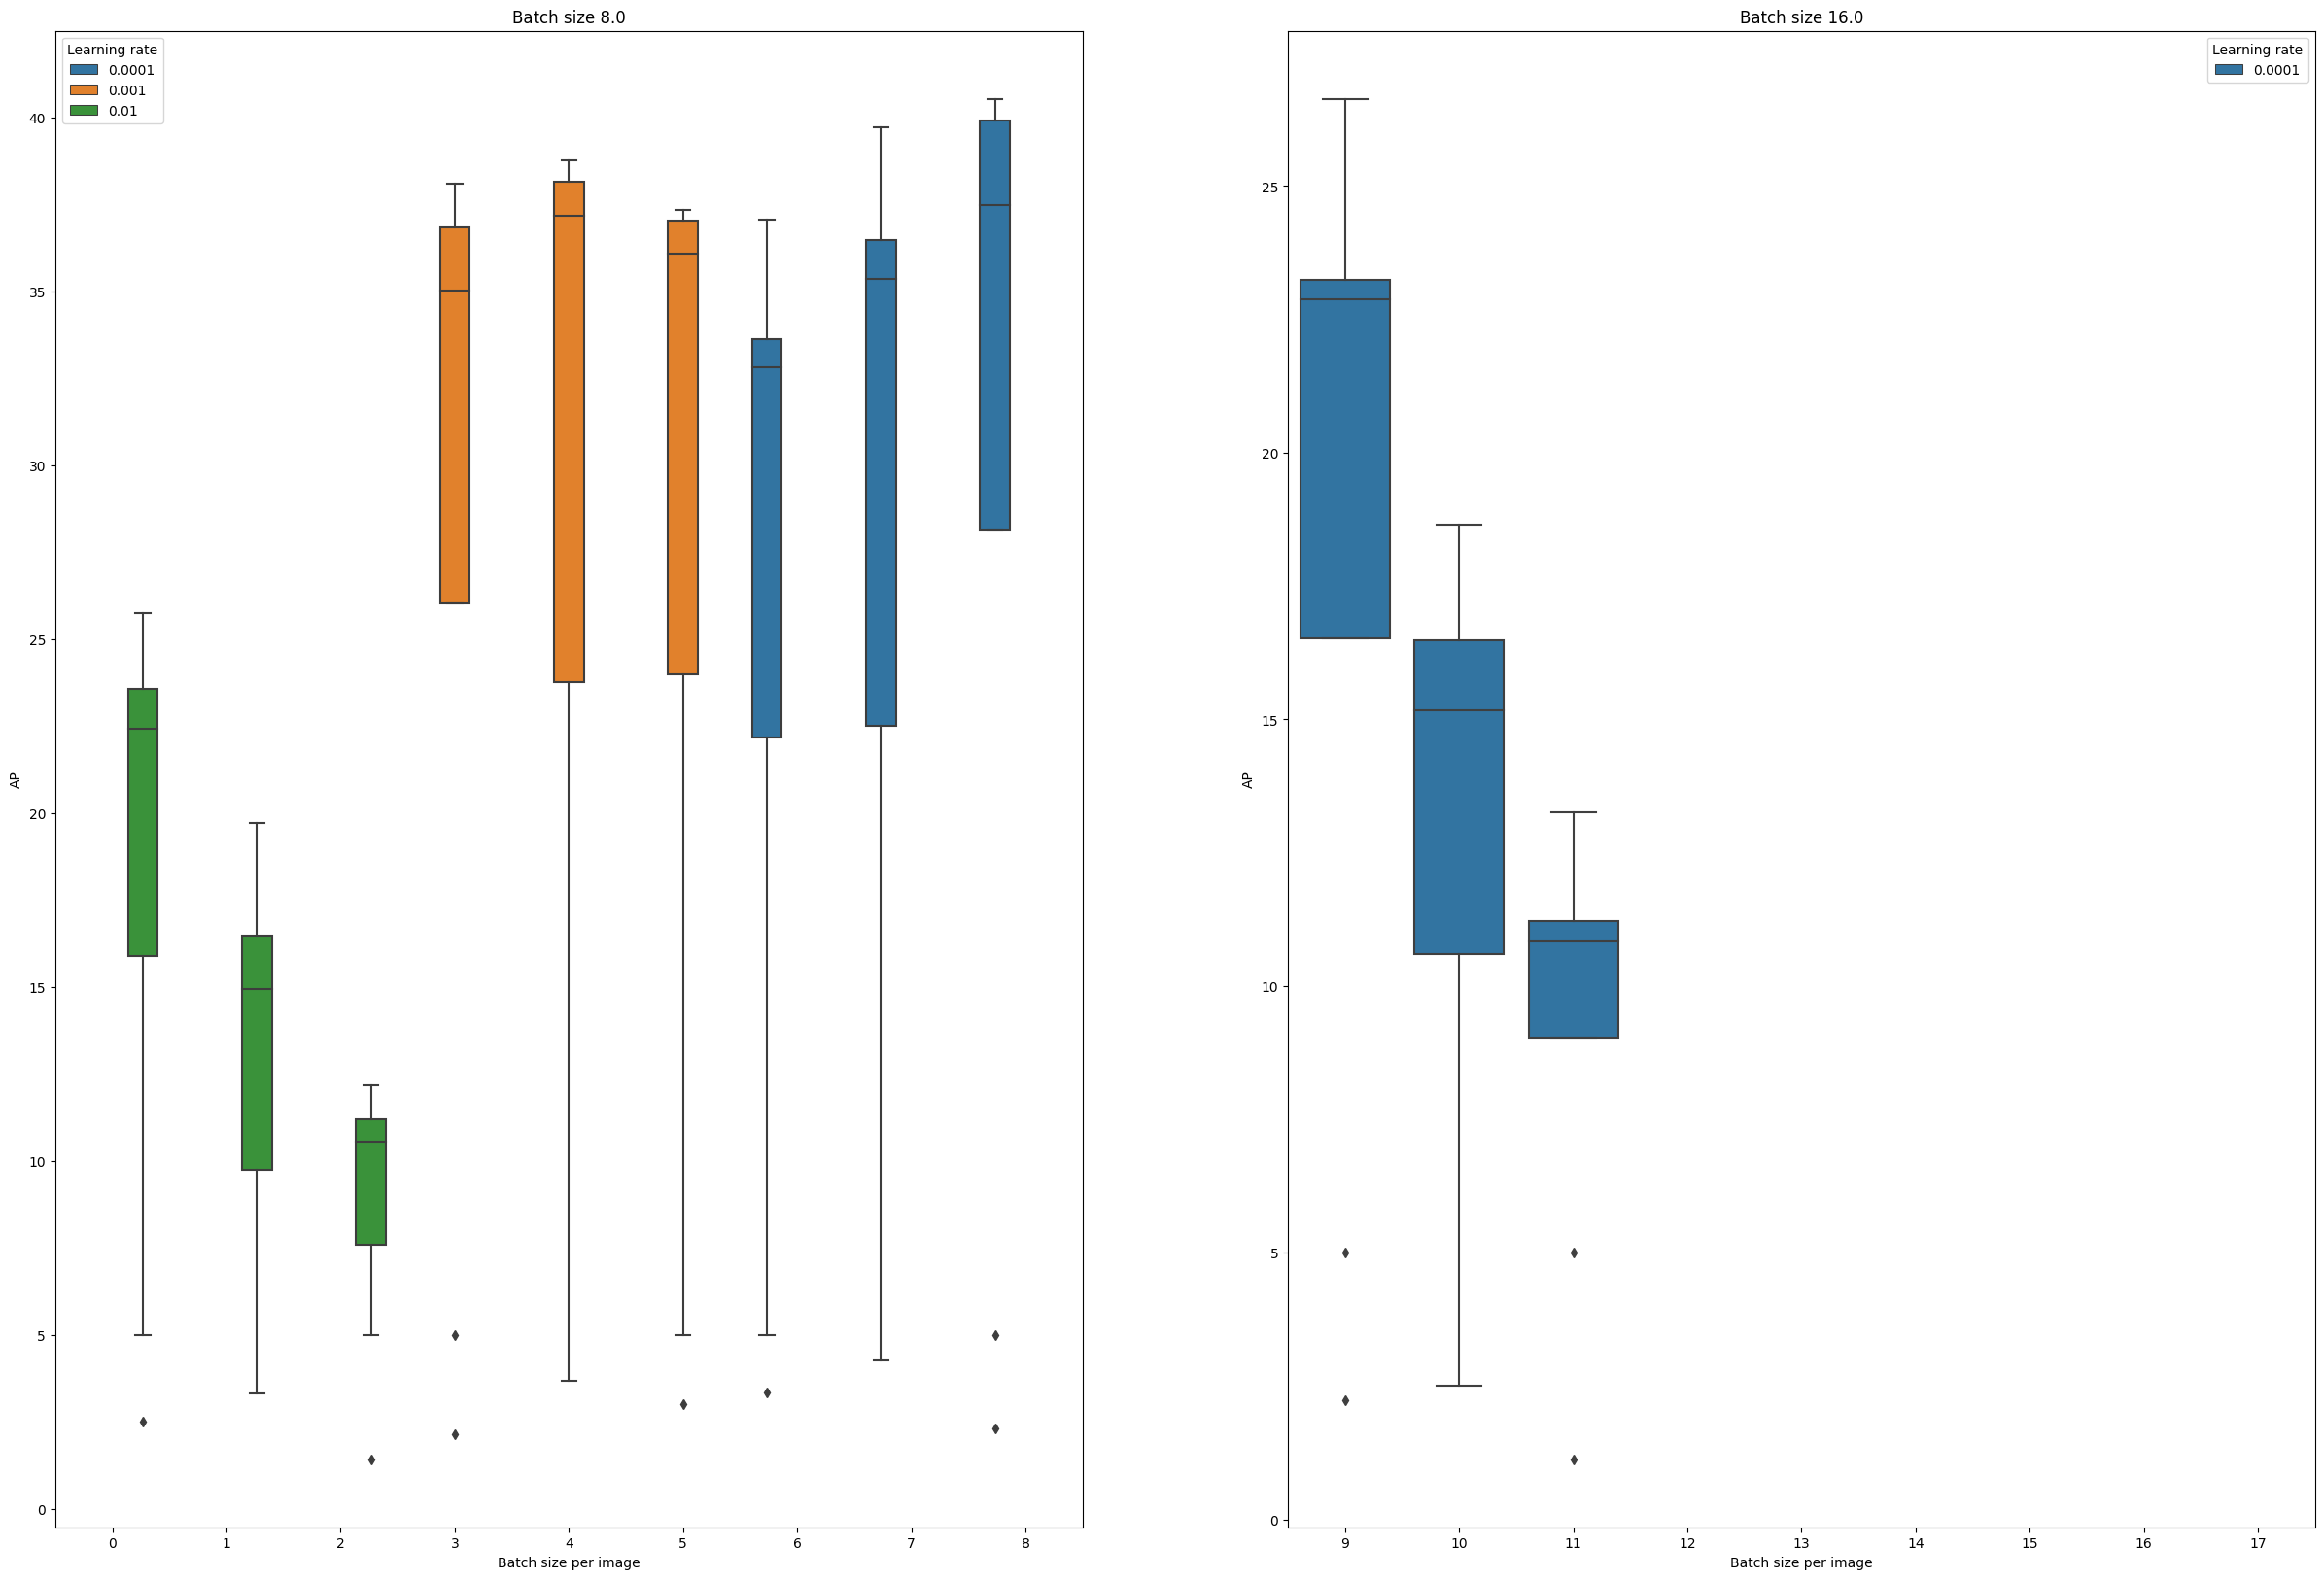

In [71]:
x_value = [128, 256, 512] * 2
x_values_df = pd.DataFrame(x_value, columns=['Batch size per image'])

hue_labels = [0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001]

fig, ax = plt.subplots(1, 2, figsize=(30, 20))

melt_bbox_0_11 = grouped_bbox_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_0_11['Learning rate'] = melt_bbox_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_0_11, hue='Learning rate', ax=ax[0])
#ax[0].set_xticklabels(x_values_df['Batch size per image'])
ax[0].set_xlabel('Batch size per image')
ax[0].set_ylabel('AP')
ax[0].set_title('Batch size 8.0')

melt_bbox_12_23 = grouped_bbox_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_12_23['Learning rate'] = melt_bbox_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=3)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_12_23, hue='Learning rate', ax=ax[1])
ax[1].set_title('Batch size 16.0')
#ax[1].set_xticklabels(x_values_df['Batch size per image'])
ax[1].set_xlabel('Batch size per image')
ax[1].set_ylabel('AP')

plt.show()

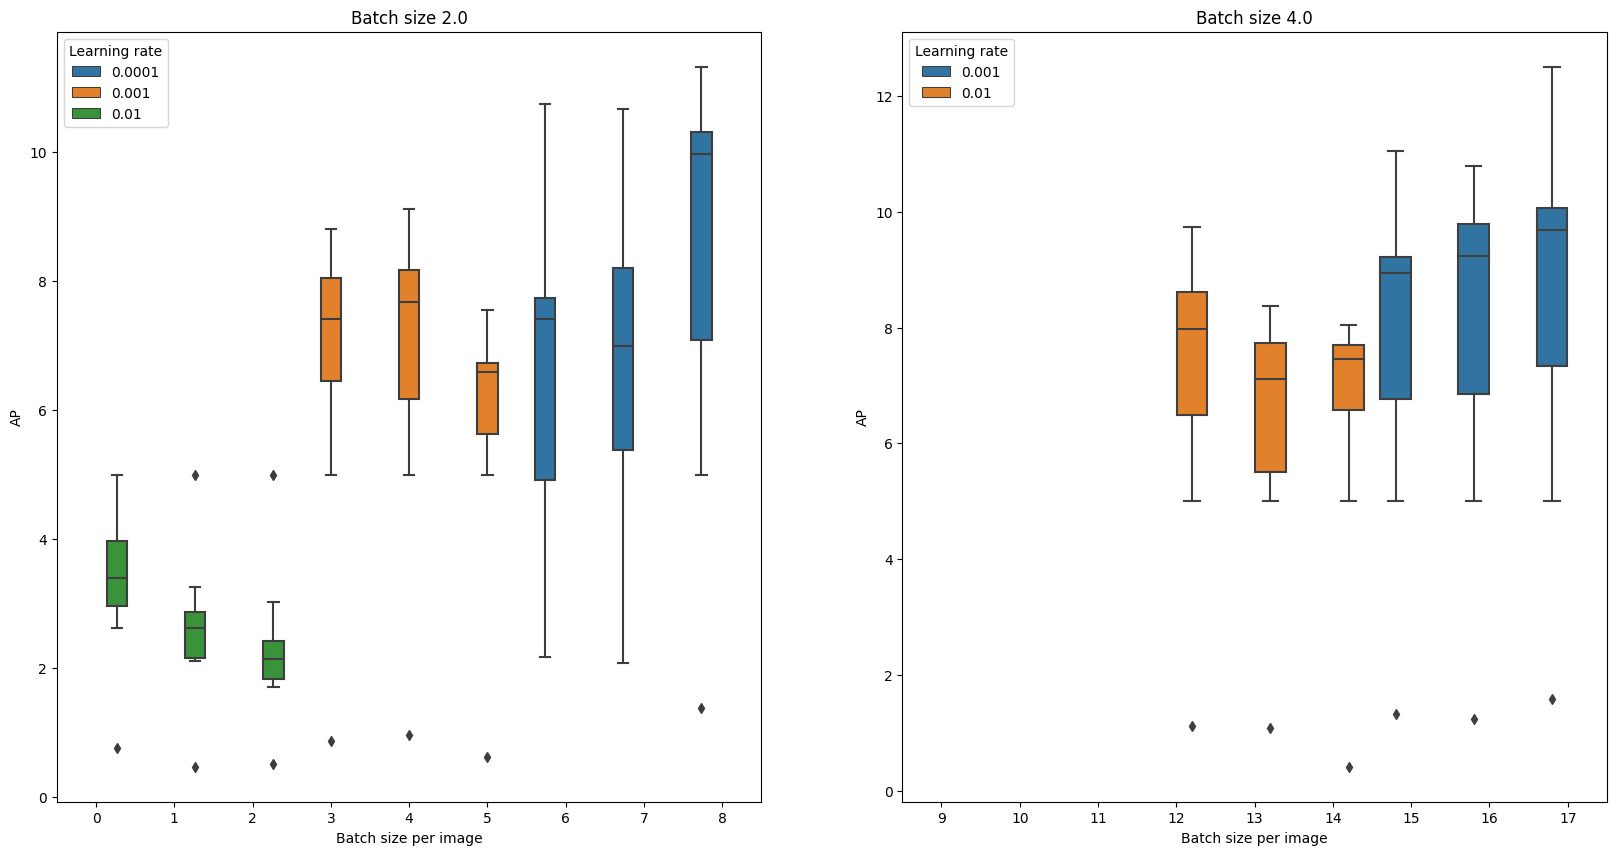

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

melt_segm_0_11 = grouped_segm_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_0_11['Learning rate'] = melt_segm_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_0_11, hue='Learning rate', ax=ax[0])
ax[0].set_xlabel('Batch size per image')
ax[0].set_ylabel('AP')
ax[0].set_title('Batch size 2.0')

melt_segm_12_23 = grouped_segm_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_12_23['Learning rate'] = melt_segm_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=12)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_12_23, hue='Learning rate', ax=ax[1])
ax[1].set_title('Batch size 4.0')
ax[1].set_xlabel('Batch size per image')
ax[1].set_ylabel('AP')

plt.show()


For both bbox and segm, the same tendency as before is shown, however now is more clear. Higher bs result in better performing, beeing the best performance bs of 8 and 10. In both bs a lr of 0.001 is the best. Also the best bspi is 128 and 256. The spected increase of the std in better performing models is expected, as nn are high variance low bias models, as they fit better to the training data, the scores in the test set will vary more. The goal is to find the best tradeoff.

# Metrics

In [73]:
best_model = "bs_16_lr_0.01_bsi_1024"
model_best_0 = convert_tb_data(f"./../models/CA_models/{best_model}/0")
model_best_1 = convert_tb_data(f"./../models/CA_models/{best_model}/1")
model_best_2 = convert_tb_data(f"./../models/CA_models/{best_model}/2")
model_best_3 = convert_tb_data(f"./../models/CA_models/{best_model}/3")
model_best_4 = convert_tb_data(f"./../models/CA_models/{best_model}/4")
model_best_0.head()

,wall_time,name,step,value
0,1.733341e+09,data_time,18,0.473149
1,1.733341e+09,rpn/num_pos_anchors,19,11.750000
2,1.733341e+09,rpn/num_neg_anchors,19,244.250000
3,1.733341e+09,roi_head/num_fg_samples,19,4.406250
4,1.733341e+09,roi_head/num_bg_samples,19,996.968750


In [74]:
second_best_model = "bs_16_lr_0.01_bsi_512"
model_secondbest_0 = convert_tb_data(f"./../models/CA_models/{second_best_model}/0")
model_secondbest_1 = convert_tb_data(f"./../models/CA_models/{second_best_model}/1")
model_secondbest_2 = convert_tb_data(f"./../models/CA_models/{second_best_model}/2")
model_secondbest_3 = convert_tb_data(f"./../models/CA_models/{second_best_model}/3")
model_secondbest_4 = convert_tb_data(f"./../models/CA_models/{second_best_model}/4")
model_secondbest_0.head()

,wall_time,name,step,value
0,1.732598e+09,data_time,18,0.472056
1,1.732598e+09,rpn/num_pos_anchors,19,10.343750
2,1.732598e+09,rpn/num_neg_anchors,19,245.656250
3,1.732598e+09,roi_head/num_fg_samples,19,4.093750
4,1.732598e+09,roi_head/num_bg_samples,19,507.906250


In [75]:
thirdbest_model = "bs_16_lr_0.01_bsi_256"
model_thirdbest_0 = convert_tb_data(f"./../models/CA_models/{thirdbest_model}/0")
model_thirdbest_1 = convert_tb_data(f"./../models/CA_models/{thirdbest_model}/1")
model_thirdbest_2 = convert_tb_data(f"./../models/CA_models/{thirdbest_model}/2")
model_thirdbest_3 = convert_tb_data(f"./../models/CA_models/{thirdbest_model}/3")
model_thirdbest_4 = convert_tb_data(f"./../models/CA_models/{thirdbest_model}/4")
model_thirdbest_0.head()

,wall_time,name,step,value
0,1.732583e+09,data_time,18,0.473099
1,1.732583e+09,rpn/num_pos_anchors,19,10.625000
2,1.732583e+09,rpn/num_neg_anchors,19,245.375000
3,1.732583e+09,roi_head/num_fg_samples,19,4.125000
4,1.732583e+09,roi_head/num_bg_samples,19,251.875000


In [76]:
model_best_0_metrics = model_best_0.pivot(index='step', columns='name', values='value')
model_best_0_metrics = model_best_0_metrics.dropna(how='all')
model_best_0_metrics_eval = model_best_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_best_1_metrics = model_best_1.pivot(index='step', columns='name', values='value')
model_best_1_metrics = model_best_1_metrics.dropna(how='all')
model_best_1_metrics_eval = model_best_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_best_2_metrics = model_best_2.pivot(index='step', columns='name', values='value')
model_best_2_metrics = model_best_2_metrics.dropna(how='all')
model_best_2_metrics_eval = model_best_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_best_3_metrics = model_best_3.pivot(index='step', columns='name', values='value')
model_best_3_metrics = model_best_3_metrics.dropna(how='all')
model_best_3_metrics_eval = model_best_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_best_4_metrics = model_best_4.pivot(index='step', columns='name', values='value')
model_best_4_metrics = model_best_4_metrics.dropna(how='all')
model_best_4_metrics_eval = model_best_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

In [77]:
model_secondbest_0_metrics = model_secondbest_0.pivot(index='step', columns='name', values='value')
model_secondbest_0_metrics = model_secondbest_0_metrics.dropna(how='all')
model_secondbest_0_metrics_eval = model_secondbest_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_secondbest_1_metrics = model_secondbest_1.pivot(index='step', columns='name', values='value')
model_secondbest_1_metrics = model_secondbest_1_metrics.dropna(how='all')
model_secondbest_1_metrics_eval = model_secondbest_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_secondbest_2_metrics = model_secondbest_2.pivot(index='step', columns='name', values='value')
model_secondbest_2_metrics = model_secondbest_2_metrics.dropna(how='all')
model_secondbest_2_metrics_eval = model_secondbest_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_secondbest_3_metrics = model_secondbest_3.pivot(index='step', columns='name', values='value')
model_secondbest_3_metrics = model_secondbest_3_metrics.dropna(how='all')
model_secondbest_3_metrics_eval = model_secondbest_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_secondbest_4_metrics = model_secondbest_4.pivot(index='step', columns='name', values='value')
model_secondbest_4_metrics = model_secondbest_4_metrics.dropna(how='all')
model_secondbest_4_metrics_eval = model_secondbest_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_secondbest_0_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,0.711385,1.341603,0.608576,0.317974,2.569032,0.524752,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,4.006093,9.337147,2.435945,5.481872,6.662794,3.091369,NaN,1537.211060,0.968628,1.000000,...,245.09375,10.90625,0.165657,0.881527,0.001666,0.495050,2.145710,0.116072,1.132960,0.500786
149,7.300800,17.332689,4.263314,10.645769,10.756556,5.657986,NaN,NaN,NaN,NaN,...,NaN,NaN,0.331313,1.763054,0.003333,0.990099,4.291420,0.232143,NaN,NaN
199,9.405770,21.301558,5.761560,13.426133,13.064046,7.638751,NaN,1411.708374,0.971008,0.665773,...,245.40625,10.59375,0.928669,4.500102,0.069324,2.698020,7.594792,0.499197,1.089038,0.386360
249,11.510739,25.270426,7.259807,16.206497,15.371535,9.619515,NaN,NaN,NaN,NaN,...,NaN,NaN,1.526024,7.237150,0.135315,4.405941,10.898163,0.766251,NaN,NaN


In [78]:
model_thirdbest_0_metrics = model_thirdbest_0.pivot(index='step', columns='name', values='value')
model_thirdbest_0_metrics = model_thirdbest_0_metrics.dropna(how='all')
model_thirdbest_0_metrics_eval = model_thirdbest_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_thirdbest_1_metrics = model_thirdbest_1.pivot(index='step', columns='name', values='value')
model_thirdbest_1_metrics = model_thirdbest_1_metrics.dropna(how='all')
model_thirdbest_1_metrics_eval = model_thirdbest_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_thirdbest_2_metrics = model_thirdbest_2.pivot(index='step', columns='name', values='value')
model_thirdbest_2_metrics = model_thirdbest_2_metrics.dropna(how='all')
model_thirdbest_2_metrics_eval = model_thirdbest_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_thirdbest_3_metrics = model_thirdbest_3.pivot(index='step', columns='name', values='value')
model_thirdbest_3_metrics = model_thirdbest_3_metrics.dropna(how='all')
model_thirdbest_3_metrics_eval = model_thirdbest_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_thirdbest_4_metrics = model_thirdbest_4.pivot(index='step', columns='name', values='value')
model_thirdbest_4_metrics = model_thirdbest_4_metrics.dropna(how='all')
model_thirdbest_4_metrics_eval = model_thirdbest_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_thirdbest_0_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,2.767674,7.713989,1.588539,2.443260,5.267767,1.699894,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,5.509926,14.048028,2.981408,9.942024,7.554132,4.576747,NaN,1469.455200,0.935669,0.991024,...,245.21875,10.78125,0.093273,0.439852,0.004635,0.214521,1.386033,0.100283,1.075437,0.679359
149,8.252178,20.382067,4.374277,17.440790,9.840495,7.453601,NaN,NaN,NaN,NaN,...,NaN,NaN,0.186546,0.879704,0.009270,0.429043,2.772066,0.200566,NaN,NaN
199,11.471967,26.390230,7.474481,23.257591,14.357807,8.758797,NaN,1362.682373,0.957886,0.326404,...,244.62500,11.37500,1.102264,5.197228,0.059448,2.817067,6.487710,0.609534,1.106134,0.473873
249,14.691755,32.398396,10.574684,29.074392,18.875120,10.063993,NaN,NaN,NaN,NaN,...,NaN,NaN,2.017982,9.514752,0.109626,5.075908,10.203355,1.018501,NaN,NaN


In [79]:
model_best_avg_metrics = (model_best_0_metrics + model_best_1_metrics + model_best_2_metrics + model_best_3_metrics + model_best_4_metrics) / 5
model_best_avg_metrics_eval = model_best_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_best_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,0.202726,0.450318,0.189533,0.330033,0.706023,0.079208,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,3.294512,8.359373,1.685530,5.250808,4.929614,2.649700,NaN,1594.657886,0.984919,1.000000,...,245.03750,10.96250,0.145523,0.655984,0.003867,0.047030,1.867913,0.100698,1.138087,0.398159
149,6.386297,16.268429,3.181527,10.171582,9.153204,5.220192,NaN,NaN,NaN,NaN,...,NaN,NaN,0.291046,1.311968,0.007734,0.094059,3.735827,0.201396,NaN,NaN
199,8.416792,20.429683,4.664847,13.225380,11.401639,7.142391,NaN,1469.221191,0.983997,0.949218,...,245.41875,10.58125,1.166207,4.969468,0.083022,1.861308,7.801067,0.518564,1.120700,0.321560
249,10.447288,24.590937,6.148167,16.279177,13.650075,9.064590,NaN,NaN,NaN,NaN,...,NaN,NaN,2.041368,8.626967,0.150626,3.437588,11.866308,0.835733,NaN,NaN


In [80]:
model_secondbest_avg_metrics = (model_secondbest_0_metrics + model_secondbest_1_metrics + model_secondbest_2_metrics + model_secondbest_3_metrics + model_secondbest_4_metrics) / 5
model_secondbest_avg_metrics_eval = model_secondbest_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_secondbest_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,1.263309,2.915700,0.965076,1.072020,2.978772,0.872851,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,4.455375,11.132123,2.437802,6.843901,6.658129,3.944476,NaN,1529.377344,0.969690,1.000000,...,244.88750,11.11250,0.217656,1.067155,0.013703,0.166667,2.414130,0.187531,1.123982,0.494174
149,7.647441,19.348546,3.910527,12.615782,10.337485,7.016102,NaN,NaN,NaN,NaN,...,NaN,NaN,0.435313,2.134310,0.027405,0.333333,4.828260,0.375062,NaN,NaN
199,9.766355,23.504369,5.395874,15.925258,12.353280,8.950993,NaN,1410.117920,0.971924,0.660197,...,244.68125,11.31875,1.270127,5.588649,0.094074,1.846281,8.078816,0.656632,1.087333,0.395811
249,11.885270,27.660192,6.881221,19.234734,14.369075,10.885884,NaN,NaN,NaN,NaN,...,NaN,NaN,2.104941,9.042988,0.153378,3.359229,11.329371,0.938202,NaN,NaN


In [81]:
model_secondbest_avg_metrics_eval = model_secondbest_avg_metrics_eval.drop(columns=['data_time'])
model_secondbest_avg_metrics_eval = model_secondbest_avg_metrics_eval.dropna()
print(model_secondbest_avg_metrics_eval.head())

name    bbox/AP  bbox/AP50  bbox/AP75   bbox/APl   bbox/APm   bbox/APs  \
step                                                                     
99     4.455375  11.132123   2.437802   6.843901   6.658129   3.944476   
199    9.766355  23.504369   5.395874  15.925258  12.353280   8.950993   
299   14.298506  31.969741   9.593945  22.110360  16.861329  12.711330   
399   19.580073  41.197137  16.150582  29.069925  22.272658  16.818212   
499   24.494257  49.358826  22.015949  35.921397  27.163797  21.108528   

name  eta_seconds  fast_rcnn/cls_accuracy  fast_rcnn/false_negative  \
step                                                                  
99    1529.377344                0.969690                  1.000000   
199   1410.117920                0.971924                  0.660197   
299   1304.174219                0.974255                  0.449370   
399   1199.144678                0.976038                  0.349852   
499   1093.753979                0.977490              

In [82]:
model_thirdbest_avg_metrics = (model_thirdbest_0_metrics + model_thirdbest_1_metrics + model_thirdbest_2_metrics + model_thirdbest_3_metrics + model_thirdbest_4_metrics) / 5
model_thirdbest_avg_metrics_eval = model_thirdbest_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_thirdbest_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,2.975590,8.976102,1.164732,3.818628,4.693245,2.496305,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,5.473453,15.358689,2.192058,8.757318,7.315709,5.153875,NaN,1469.373145,0.936963,0.973177,...,244.60000,11.40000,0.215550,1.023109,0.006768,0.092409,2.240848,0.197907,1.059823,0.668170
149,7.971315,21.741277,3.219385,13.696008,9.938174,7.811445,NaN,NaN,NaN,NaN,...,NaN,NaN,0.431100,2.046218,0.013536,0.184818,4.481696,0.395815,NaN,NaN
199,11.203946,28.040280,5.848321,17.839158,13.655631,10.162003,NaN,1362.795972,0.954077,0.329567,...,245.33125,10.66875,1.408719,5.961939,0.085433,1.515531,7.581589,0.921974,1.086777,0.484594
249,14.436576,34.339283,8.477257,21.982309,17.373088,12.512561,NaN,NaN,NaN,NaN,...,NaN,NaN,2.386338,9.877661,0.138559,2.820408,10.653355,1.448134,NaN,NaN


In [83]:
model_secondbest_avg_metrics.columns

Index(['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APl', 'bbox/APm', 'bbox/APs',
       'data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy',
       'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'loss_box_reg',
       'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr',
       'mask_rcnn/accuracy', 'mask_rcnn/false_negative',
       'mask_rcnn/false_positive', 'roi_head/num_bg_samples',
       'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors',
       'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APl', 'segm/APm', 'segm/APs',
       'time', 'total_loss'],
      dtype='object', name='name')

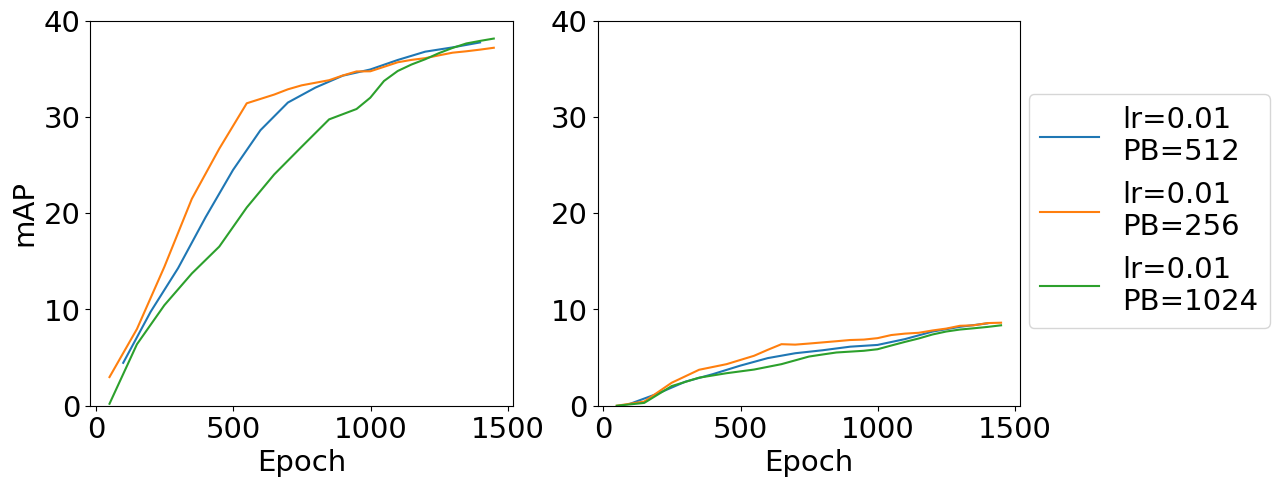

In [84]:
fs=21
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for bbox/AP and segm/AP
model_secondbest_avg_metrics_eval.plot(
    y='bbox/AP', ax=ax[0], label='Learning rate=0.01, Proposed boxes=512'
)
model_secondbest_avg_metrics_eval.plot(
    y='segm/AP', ax=ax[1], label='Learning rate=0.01, Proposed boxes=512'
)
model_thirdbest_avg_metrics_eval.plot(
    y='bbox/AP', ax=ax[0], label='Learning rate=0.01, Proposed boxes=256'
)
model_thirdbest_avg_metrics_eval.plot(
    y='segm/AP', ax=ax[1], label='Learning rate=0.01, Proposed boxes=256'
)
model_best_avg_metrics_eval.plot(
    y='bbox/AP', ax=ax[0], label='Learning rate=0.01, Proposed boxes=1024'
)
model_best_avg_metrics_eval.plot(
    y='segm/AP', ax=ax[1], label='Learning rate=0.01, Proposed boxes=1024'
)

# Set labels and limits for the first subplot
ax[0].set_xlabel('Epoch', fontsize=fs)
ax[0].set_ylabel('mAP', fontsize=fs)
ax[0].set_ylim(0, 40)
ax[0].tick_params(axis='y', which='major', labelsize=fs)
ax[0].tick_params(axis='x', which='major', labelsize=fs)
#ax[0].set_title('Bounding Box mAP', fontsize=25)

# Set labels and limits for the second subplot
ax[1].set_xlabel('Epoch', fontsize=fs)
#ax[1].set_ylabel('mAP', fontsize=fs)
ax[1].set_ylim(0, 40)
ax[1].tick_params(axis='y', which='major', labelsize=fs)
ax[1].tick_params(axis='x', which='major', labelsize=fs)
#ax[1].set_title('Segmentation mAP', fontsize=25)

# Combine legends from both plots
lines, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
ax[1].get_legend().remove()
fig.legend(lines, ['lr=0.01\nPB=512', 
                   'lr=0.01\nPB=256', 
                   'lr=0.01\nPB=1024'], 
           loc='right', fontsize=fs, bbox_to_anchor=(1.12, 0.5))

plt.savefig("../../plots/ca_comparing_final_models.png", dpi=300, bbox_inches='tight')
plt.show()

Comparing our two best performant models we can see that in bbox AP model 50 works better. It starts learning slower but is better guided to the optimal solution, in contrast to model 38 that starts learning faster but quickly platues and does not improve. In segm eventhough is tighter, model 38 wins by a margin, however its behaviour is less expected, it learns quicly but looks like its going to plateu but then it improves before overfitting and decreasing in performance. In the contrary model 50 starts learning slower but is more stable and improves more steadily.

## Overfitting

Given the results comparing both models, it can be seen that model 50 is more stable and yield a better performance. This is because it is less prone to overfitting, as it learns slower but more steadily. Now that we have stablished the best resulting model, we can evaluate the overfitting of the model by comparing the performance in training and validation. 

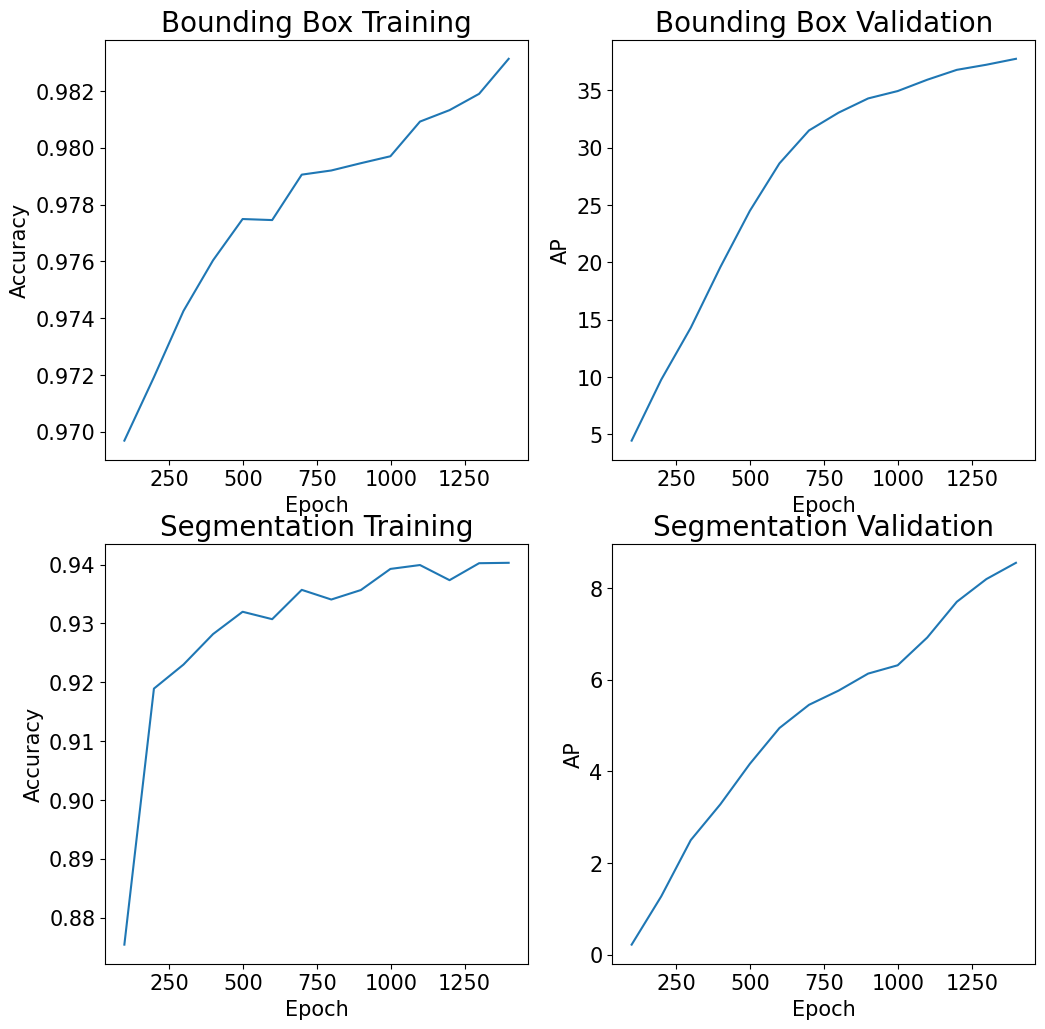

In [85]:
# Plot the curve of the average of model 50 that compares bbox/AP to fast_rcnn/cls_accuracy and segm/AP to mask_rcnn/accuracy, set log scale on the y-axis
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

model_secondbest_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0][1], legend=False)
model_secondbest_avg_metrics_eval.plot(y='fast_rcnn/cls_accuracy', ax=ax[0][0], legend=False)
model_secondbest_avg_metrics_eval.plot(y='segm/AP', ax=ax[1][1], legend=False)
model_secondbest_avg_metrics_eval.plot(y='mask_rcnn/accuracy', ax=ax[1][0], legend=False)

#ax[0][1].legend(fontsize=20)
ax[0][0].set_title('Bounding Box Training', fontsize=20)
ax[0][0].set_xlabel('Epoch', fontsize=15)
ax[0][0].set_ylabel('Accuracy', fontsize=15)
ax[0][0].tick_params(axis='both', which='major', labelsize=15)

#ax[0][0].legend(fontsize=20)
ax[0][1].set_title('Bounding Box Validation', fontsize=20)
ax[0][1].set_xlabel('Epoch', fontsize=15)
ax[0][1].set_ylabel('AP', fontsize=15)
ax[0][1].tick_params(axis='both', which='major', labelsize=15)

#ax[1][1].legend(fontsize=20)
ax[1][0].set_title('Segmentation Training', fontsize=20)
ax[1][0].set_xlabel('Epoch', fontsize=15)
ax[1][0].set_ylabel('Accuracy', fontsize=15)
ax[1][0].tick_params(axis='both', which='major', labelsize=15)

#ax[1][0].legend(fontsize=20)
ax[1][1].set_title('Segmentation Validation', fontsize=20)
ax[1][1].set_xlabel('Epoch', fontsize=15)
ax[1][1].set_ylabel('AP', fontsize=15)
ax[1][1].tick_params(axis='both', which='major', labelsize=15)

plt.show()

# Final model

Final model trained on all data for 3500 epoch, configuration bs=10, lr=0.001, bspi=256

In [86]:
final_0 = convert_tb_data("./../models/CA_final_model/0")
final_1 = convert_tb_data("./../models/CA_final_model/1")
final_2 = convert_tb_data("./../models/CA_final_model/2")
final_3 = convert_tb_data("./../models/CA_final_model/3")
final_4 = convert_tb_data("./../models/CA_final_model/4")

final_0.head()

,wall_time,name,step,value
0,1.733948e+09,data_time,18,0.823233
1,1.733948e+09,rpn/num_pos_anchors,19,11.343750
2,1.733948e+09,rpn/num_neg_anchors,19,244.656250
3,1.733948e+09,roi_head/num_fg_samples,19,4.593750
4,1.733948e+09,roi_head/num_bg_samples,19,996.781250


In [87]:
final_0 = final_0.pivot(index='step', columns='name', values='value')
final_0 = final_0.drop(columns=['data_time'])
final_0 = final_0.dropna(axis=0, how='any')

final_1 = final_1.pivot(index='step', columns='name', values='value')
final_1 = final_1.drop(columns=['data_time'])
final_1 = final_1.dropna(axis=0, how='any')

final_2 = final_2.pivot(index='step', columns='name', values='value')
final_2 = final_2.drop(columns=['data_time'])
final_2 = final_2.dropna(axis=0, how='any')

final_3 = final_3.pivot(index='step', columns='name', values='value')
final_3 = final_3.drop(columns=['data_time'])
final_3 = final_3.dropna(axis=0, how='any')

final_4 = final_4.pivot(index='step', columns='name', values='value')
final_4 = final_4.drop(columns=['data_time'])
final_4 = final_4.dropna(axis=0, how='any')

final_0.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,4.091547,9.038034,3.100390,4.729702,6.452080,2.801742,3279.857666,0.984087,1.000000,0.000000,...,245.06250,10.93750,0.254035,1.297690,0.004360,0.181518,2.364051,0.160577,1.127975,0.403633
199,9.729597,21.349100,7.107691,11.835426,14.415012,7.167316,3168.989258,0.983276,0.957255,0.023811,...,244.46875,11.53125,1.214874,5.379162,0.113565,2.651665,8.294335,0.509003,1.138580,0.316982
299,13.186759,27.702242,10.203208,16.997919,18.527462,10.011037,3072.129395,0.984021,0.684845,0.201270,...,245.59375,10.40625,2.318869,10.372316,0.232658,4.920642,11.954350,0.831807,1.140225,0.294154
399,16.859434,33.572926,15.090049,23.028486,22.045650,14.138288,2958.346680,0.984801,0.581787,0.275327,...,244.62500,11.37500,2.821417,13.440972,0.257156,5.558706,11.954350,0.968567,1.153528,0.275366
499,20.475016,38.290829,20.623604,29.806993,25.292469,17.865438,2857.962646,0.984240,0.550724,0.379566,...,244.50000,11.50000,3.096014,14.628531,0.257156,6.207371,12.374279,1.285622,1.178540,0.277450


In [88]:
final_avg = (final_0 + final_1 + final_2 + final_3 + final_4) / 5
final_avg = final_avg.dropna(subset=['bbox/AP', 'segm/AP'])
final_avg.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,3.351381,8.192178,2.007575,5.013142,4.972953,2.964291,3320.472900,0.984478,1.000000,0.000000,...,245.42500,10.57500,0.150700,0.732752,0.003602,0.036304,1.976502,0.111071,1.141745,0.403219
199,8.495446,19.941494,5.518257,12.740651,11.778786,7.165676,3189.735547,0.983654,0.967816,0.019100,...,244.80000,11.20000,1.182862,4.991573,0.079707,1.959635,7.945773,0.482042,1.137196,0.322009
299,11.961216,26.540059,8.453973,17.637482,15.539317,9.822189,3081.676514,0.983253,0.704275,0.187542,...,245.28125,10.71875,2.328931,9.845861,0.177833,3.854025,12.192854,0.959165,1.145359,0.291428
399,15.050207,32.145930,11.677987,21.205373,18.415603,13.088214,2964.643994,0.983897,0.605669,0.286587,...,245.47500,10.52500,2.834011,12.044144,0.218657,4.172880,12.574178,1.398462,1.141154,0.274128
499,18.752021,38.386184,16.042228,26.653720,22.196924,16.272478,2862.948340,0.984352,0.499088,0.414731,...,244.72500,11.27500,3.423986,13.925204,0.246095,4.570859,12.881455,1.909759,1.172469,0.265992


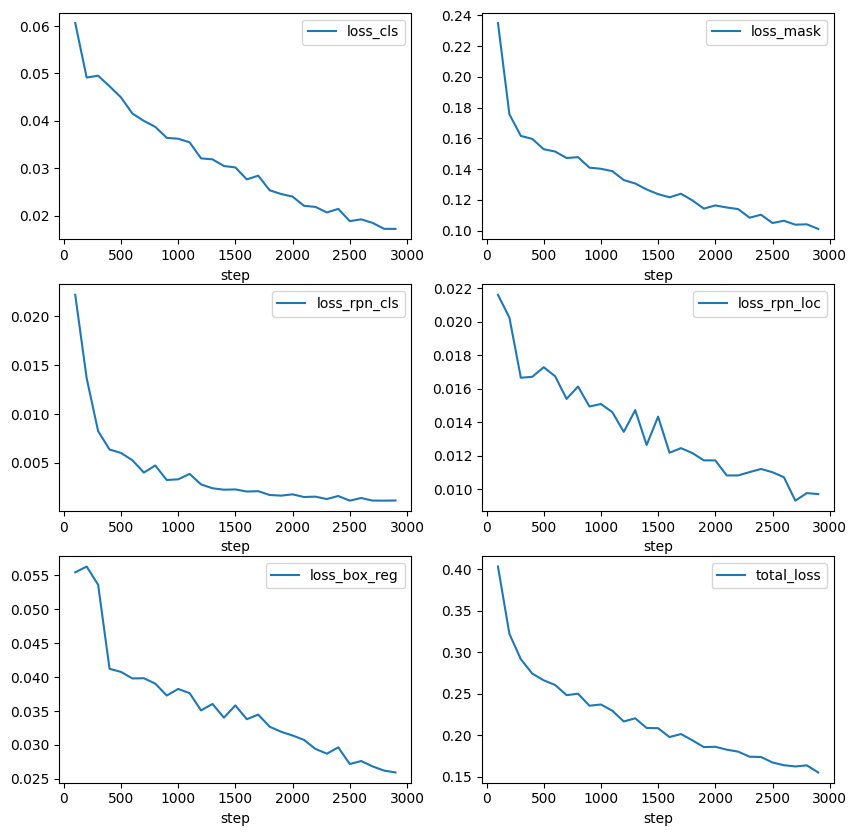

In [89]:
fig, ax = plt.subplots(3,2, figsize=(10, 10))

final_avg.plot(y='loss_cls', ax=ax[0][0], label='loss_cls')
final_avg.plot(y='loss_mask', ax=ax[0][1], label='loss_mask')
final_avg.plot(y='loss_rpn_cls', ax=ax[1][0], label='loss_rpn_cls')
final_avg.plot(y='loss_rpn_loc', ax=ax[1][1], label='loss_rpn_loc')
final_avg.plot(y='loss_box_reg', ax=ax[2][0], label='loss_box_reg')
final_avg.plot(y='total_loss', ax=ax[2][1], label='total_loss')

plt.show()

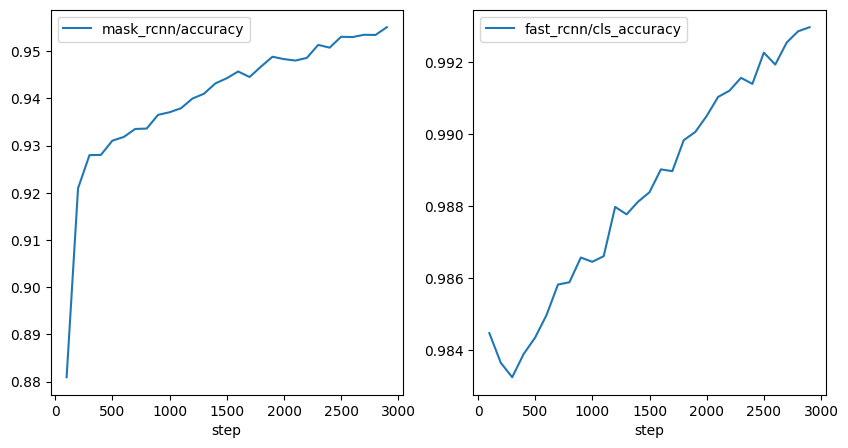

In [90]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

final_avg.plot(y='mask_rcnn/accuracy', ax=ax[0], label='mask_rcnn/accuracy')
final_avg.plot(y='fast_rcnn/cls_accuracy', ax=ax[1], label='fast_rcnn/cls_accuracy')

plt.show()

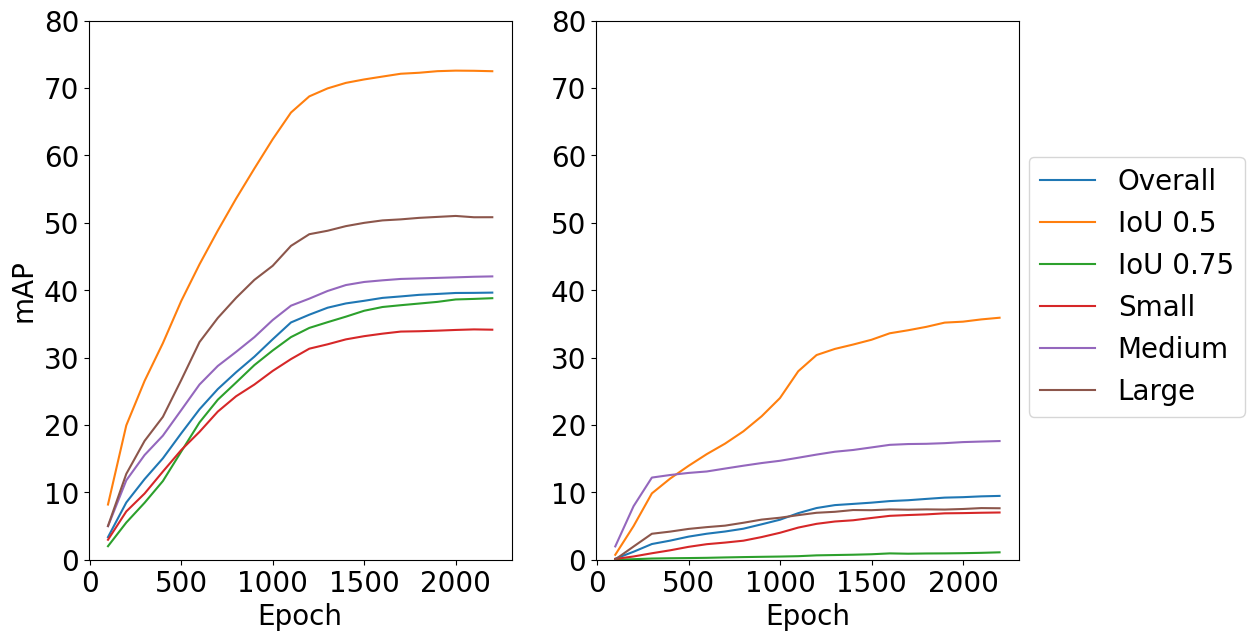

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

# Get final average until epoch 2000, this means that step is 2000
final_avg = final_avg[final_avg.index <= 2200]
bbox_lines = final_avg.plot(
    y=['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl'], 
    ax=ax[0]
)
segm_lines = final_avg.plot(
    y=['segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl'], 
    ax=ax[1]
)

# Set labels and limits for the first subplot
ax[0].set_xlabel('Epoch', fontsize=20)
ax[0].set_ylabel('mAP', fontsize=20)
ax[0].set_ylim(0, 80)
ax[0].tick_params(axis='y', which='major', labelsize=20)
ax[0].tick_params(axis='x', which='major', labelsize=20)

# Set labels and limits for the second subplot
ax[1].set_xlabel('Epoch', fontsize=20)
#ax[1].set_ylabel('mAP', fontsize=20)
ax[1].set_ylim(0, 80)
ax[1].tick_params(axis='y', which='major', labelsize=20)
ax[1].tick_params(axis='x', which='major', labelsize=20)

# Combine legends from both plots
lines, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
ax[1].get_legend().remove()
fig.legend(lines, ['Overall', 'IoU 0.5', 'IoU 0.75', 'Small', 'Medium', 'Large'], 
           loc='right', fontsize=20, bbox_to_anchor=(1.10, 0.5))

plt.savefig("../../plots/ca_final_model_of.png", dpi=300, bbox_inches='tight')
plt.show()

In [92]:
final_avg_metrics_last_epoch = final_avg.iloc[-1]
final_avg_metrics_last_epoch

name
bbox/AP                       39.645419
bbox/AP50                     72.506374
bbox/AP75                     38.816178
bbox/APl                      50.835860
bbox/APm                      42.052360
bbox/APs                      34.141075
eta_seconds                  972.813867
fast_rcnn/cls_accuracy         0.991206
fast_rcnn/false_negative       0.202255
fast_rcnn/fg_cls_accuracy      0.790608
loss_box_reg                   0.029416
loss_cls                       0.021827
loss_mask                      0.113952
loss_rpn_cls                   0.001544
loss_rpn_loc                   0.010829
lr                             0.010000
mask_rcnn/accuracy             0.948572
mask_rcnn/false_negative       0.162711
mask_rcnn/false_positive       0.030092
roi_head/num_bg_samples      975.306250
roi_head/num_fg_samples       26.006250
rpn/num_neg_anchors          245.381250
rpn/num_pos_anchors           10.618750
segm/AP                        9.471326
segm/AP50                     35.91

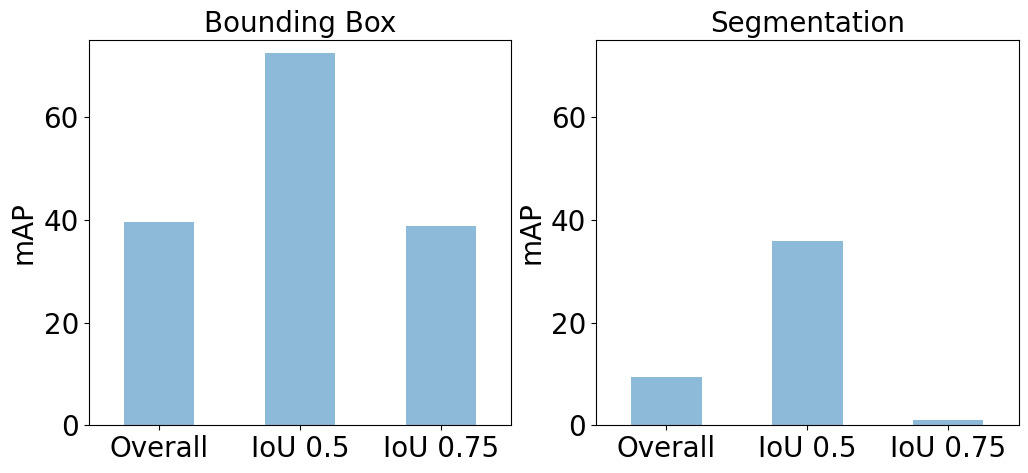

In [98]:
# Plot bar chart of the final model at the last epoch
#final_avg_metrics_last_epoch = final_avg.iloc[-1]
fs = 20
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

bbox_metrics = ['bbox/AP', 'bbox/AP50', 'bbox/AP75']
segm_metrics = ['segm/AP', 'segm/AP50', 'segm/AP75']

# Plotting bbox metrics
final_avg_metrics_last_epoch[bbox_metrics].plot(kind='bar', ax=ax[0], alpha=0.5, label='Bounding Box', color='#1f77b4', position=0.5)

# Plotting segm metrics
final_avg_metrics_last_epoch[segm_metrics].plot(kind='bar', ax=ax[1], alpha=0.5, label='Segmentation', color='#1f77b4', position=0.5)

# Set x-axis limits
ax[0].set_ylim(0, 75)
ax[1].set_ylim(0, 75)

# Customize bbox plot
ax[0].set_title('Bounding Box', fontsize=fs)
ax[0].set_ylabel('mAP', fontsize=fs)
ax[0].set_xlabel('', fontsize=fs)
ax[0].set_xticklabels(['Overall', 'IoU 0.5', 'IoU 0.75'], rotation=0, fontsize=fs)
ax[0].tick_params(axis='y', labelsize=fs)

# Customize segm plot
ax[1].set_title('Segmentation', fontsize=fs)
ax[1].set_ylabel('mAP', fontsize=fs)
ax[1].set_xlabel('', fontsize=fs)
ax[1].set_xticklabels(['Overall', 'IoU 0.5', 'IoU 0.75'], rotation=0, fontsize=fs)
ax[1].tick_params(axis='y', labelsize=fs)

plt.savefig("../../plots/ca_final_models_evals.png", dpi=300, bbox_inches='tight')
plt.show()


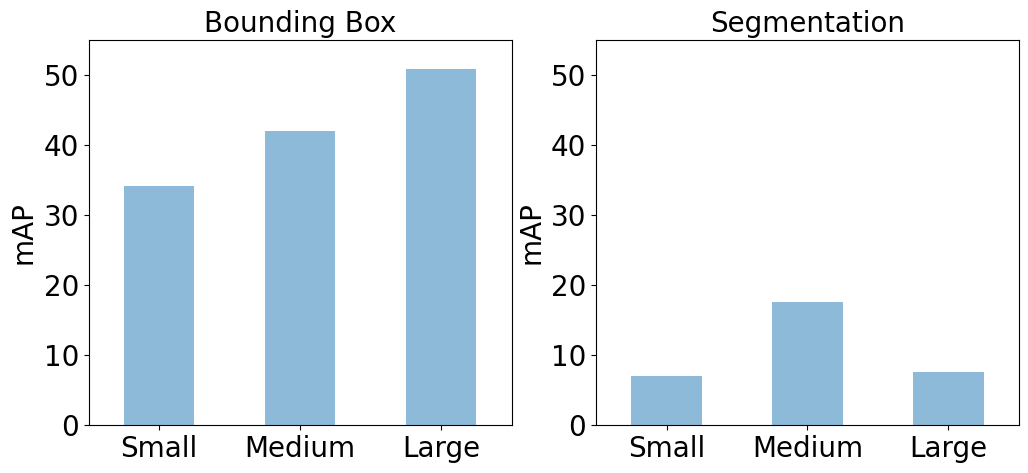

In [99]:
# Plot bar chart of the final model at the last epoch
#final_avg_metrics_last_epoch = final_avg.iloc[-1]
fs = 20
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

bbox_metrics = ['bbox/APs', 'bbox/APm', 'bbox/APl']
segm_metrics = ['segm/APs', 'segm/APm', 'segm/APl']

# Plotting bbox metrics
final_avg_metrics_last_epoch[bbox_metrics].plot(kind='bar', ax=ax[0], alpha=0.5, label='Bounding Box', color='#1f77b4', position=0.5)

# Plotting segm metrics
final_avg_metrics_last_epoch[segm_metrics].plot(kind='bar', ax=ax[1], alpha=0.5, label='Segmentation', color='#1f77b4', position=0.5)

# Set x-axis limits
ax[0].set_ylim(0, 55)
ax[1].set_ylim(0, 55)

# Customize bbox plot
ax[0].set_title('Bounding Box', fontsize=fs)
ax[0].set_ylabel('mAP', fontsize=fs)
ax[0].set_xlabel('', fontsize=fs)
ax[0].set_xticklabels(['Small', 'Medium', 'Large'], rotation=0, fontsize=fs)
ax[0].tick_params(axis='y', labelsize=fs)

# Customize segm plot
ax[1].set_title('Segmentation', fontsize=fs)
ax[1].set_ylabel('mAP', fontsize=fs)
ax[1].set_xlabel('', fontsize=fs)
ax[1].set_xticklabels(['Small', 'Medium', 'Large'], rotation=0, fontsize=fs)
ax[1].tick_params(axis='y', labelsize=fs)

plt.savefig("../../plots/ca_final_models_evals_size.png", dpi=300, bbox_inches='tight')
plt.show()


In [95]:
unet_segm_results = [9.60, 10.77, 7.83]

In [96]:
# Create a DataFrame for the new data
additional_data = {
    'Metric': ['Overall', 'IoU 0.5', 'IoU 0.75'],
    'unet_segm': unet_segm_results,
}
additional_df = pd.DataFrame(additional_data)


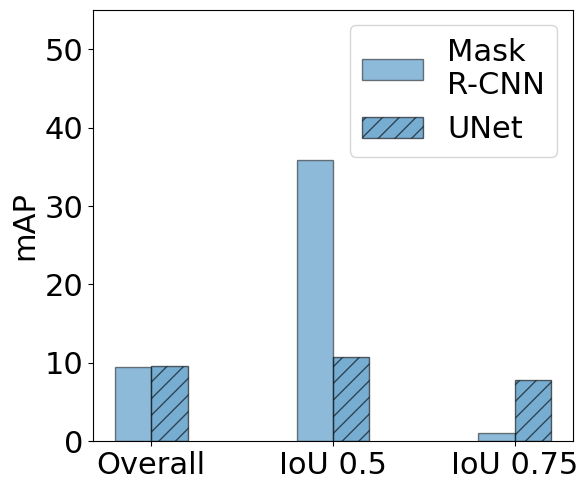

In [97]:
segm_metrics = ['segm/AP', 'segm/AP50', 'segm/AP75']

fs = 22
x_labels = ['Overall', 'IoU 0.5', 'IoU 0.75']
# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Set bar width and positions
bar_width = 0.2
index = np.arange(len(x_labels))

# Plotting Final Model Metrics
ax.bar(index, final_avg_metrics_last_epoch[segm_metrics].values.flatten(), bar_width,
       alpha=0.5, label='Mask\nR-CNN', color='#1f77b4', edgecolor='black')

# Plotting UNet Metrics
ax.bar(index + bar_width, unet_segm_results, bar_width,
       alpha=0.6, label='UNet', color='#1f77b4', hatch='//', edgecolor='black')

# Customize the plot
#ax.set_title('CA Dataset: mAP for Mask R-CNN vs UNet', fontsize=fs)
ax.set_ylabel('mAP', fontsize=fs)
#ax.set_xlabel('Metric', fontsize=fs)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_labels, rotation=0, fontsize=fs)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fs)
ax.set_ylim(0, 55)
ax.legend(fontsize=fs)

# Show the plot
plt.tight_layout()
plt.savefig("../../plots/ca_dataset_baselines.png", dpi=300, bbox_inches='tight')
plt.show()
